In [1]:
# the building we want to run
building_id = 3
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 40
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-cost"
number_of_opt_evaluations = 50
run_i = 1
iteration = 68
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,building_id,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
import time
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
      if not os.path.exists(directory):
          os.makedirs(directory)
    except:
      time.sleep(10)
      if not os.path.exists(directory):
          os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


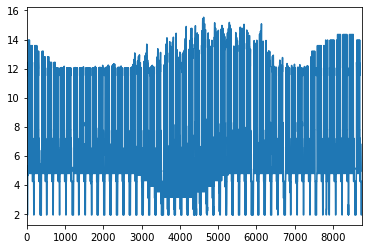

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.56
14.35221199000051


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

energy_plus/output_energy_plus/rbf-cost-106-2-1/eplusout.sql
Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3535749912261963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.272414207458496 sec


ERROR:root:Finished Generation of Irradiance


0.0


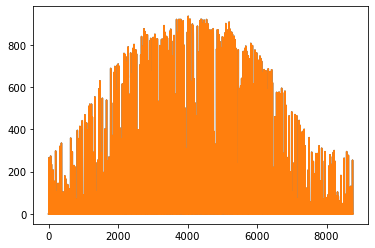

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,845 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.56


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2686967849731445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.137589693069458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.127662181854248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


INFO:root:Constraint: calc_investment_cost


INFO:root:Constraint: calc_maintenance_cost


INFO:root:Constraint: calc_operating_cost


INFO:root:Constraint: calc_total_carbon


INFO:root:Constraint: calc_total_cost


INFO:root:Constraint: constrain_max_energy


INFO:root:Constraint: daily_c_lower_medlar


INFO:root:Constraint: daily_c_lower_small


INFO:root:Constraint: daily_c_upper_medlar


INFO:root:Constraint: daily_c_upper_small


INFO:root:Constraint: energy_balance


INFO:root:Constraint: force_install


INFO:root:Constraint: large_lower


INFO:root:Constraint: large_operating_export_lower


INFO:root:Constraint: large_operating_export_upper


INFO:root:Constraint: large_operating_import_lower


INFO:root:Constraint: large_operating_import_upper


INFO:root:Constraint: large_upper


INFO:root:Constraint: max_carbon_level


INFO:root:Constraint: max_track_constraint


INFO:root:Constraint: med_operating_export_lower


INFO:root:Constraint: med_operating_export_upper


INFO:root:Constraint: med_operating_import_lower


INFO:root:Constraint: med_operating_import_upper


INFO:root:Constraint: medium_lower


INFO:root:Constraint: medium_upper


INFO:root:Constraint: monthly_bill_lower


INFO:root:Constraint: monthly_bill_upper


INFO:root:Constraint: monthly_export_constraint


INFO:root:Constraint: monthly_import_constraint


INFO:root:Constraint: net_metering_constraint


INFO:root:Constraint: roof_tech_area_below_max


INFO:root:Constraint: roof_tech_area_definition


INFO:root:Constraint: roof_tech_cap_max


INFO:root:Constraint: small_demand_charge_constraint


INFO:root:Constraint: small_operating_export_lower


INFO:root:Constraint: small_operating_export_upper


INFO:root:Constraint: small_operating_import_lower


INFO:root:Constraint: small_operating_import_upper


INFO:root:Constraint: storage_balance


INFO:root:Constraint: storage_charge_rate


INFO:root:Constraint: storage_discharge_rate


INFO:root:Constraint: storage_input_positive


INFO:root:Constraint: storage_is_installed


INFO:root:Constraint: storage_is_installed_2


INFO:root:Constraint: storage_level_above_minimum


INFO:root:Constraint: storage_level_below_capacity


INFO:root:Constraint: storage_level_positive


INFO:root:Constraint: storage_looping


INFO:root:Constraint: storage_output_positive


INFO:root:Constraint: tech_export_positive


INFO:root:Constraint: tech_import_positive


INFO:root:Constraint: tech_input_below_capacity


INFO:root:Constraint: tech_input_positive


INFO:root:Constraint: tech_is_installed


INFO:root:Constraint: tech_is_installed_2


INFO:root:Constraint: tech_is_on


INFO:root:Constraint: tech_is_on_2


INFO:root:Constraint: tech_part_loads


INFO:root:Constraint: total_export_value_constraint


INFO:root:Constraint: total_import_value_constraint


INFO:root:Constraint: total_roof_area_definition


INFO:root:Constraint: track_above_150_constraint_lower


INFO:root:Constraint: track_above_150_constraint_upper


INFO:root:Constraint: track_above_35_constraint_lower


INFO:root:Constraint: track_above_35_constraint_upper


INFO:root:Constraint: track_above_550_constraint_lower


INFO:root:Constraint: track_above_550_constraint_upper


INFO:root:Constraint: track_any_above_150_constraint_lower


INFO:root:Constraint: track_any_above_150_constraint_upper


INFO:root:Constraint: track_any_above_35_constraint_lower


INFO:root:Constraint: track_any_above_35_constraint_upper


INFO:root:Constraint: track_or_constraint_lower


INFO:root:Constraint: track_or_constraint_upper


INFO:root:Constraint: track_or_constraint_upper2


INFO:root:Constraint List: capacity_bounds


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


None


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [307.53518498812736, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.5574048188814


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


Total Electricity Imported from the grid 50,271 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 3,188 per year


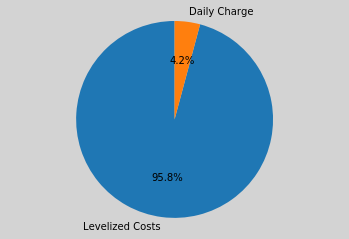

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

50270.728631185906

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr     3953.588272
Aug     4232.535574
Dec     4728.407874
Feb     4220.904101
Jan     4695.625513
Jul     3596.797122
Jun     3505.544383
Mar     4553.295110
May     3930.927926
Nov     4284.410932
Oct     4521.675077
Sep     4047.016748
monthly_import    50270.728631
dtype: float64
50270.728631185906
     monthly_export
Apr     6047.180913
Aug     6614.423308
Dec      804.969294
Feb     2251.160819
Jan      895.761370
Jul     7708.016021
Jun     6371.405780
Mar     3649.482470
May     7091.115573
Nov      925.105855
Oct     2596.898286
Sep     5315.108943
monthly_export    50270.628631
dtype: float64
50270.62863118734
133.0424999999616


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.0424999999616

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng           1.0
Grid               1.0
Invertor           1.0
PV0                1.0
PV1                0.0
PV2                0.0

In [23]:
my_model.solveResults['solution']['any_above_35']

0.0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0.0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings,
                         force_install=False)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 50


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (122.68193524482868, 204.58336003847805, 118.47695387882227, 17.390369238316616, 33.783842651516764, 51.757534194682755, 0.706705655875927, 0.8414758795008332, 0.3920752825896765)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 17.4
                                           and a gcr of 0.707


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6116831302642822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 33.8
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2291722297668457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 118
                                           a tilt of 51.8
                                           and a gcr of 0.392


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2031402587890625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [327.0608093537845, 0.0, 0.0]


ERROR:ga_logger:Cost: 3381.489797332057


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (197.5768923309576, 133.0118664777023, 188.48281127006834, 11.408801056316486, 2.9759799692199675, 19.133107606284256, 0.3783943685260812, 0.501499757070974, 0.27696126381696273)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 11.4
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2341806888580322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 3.0
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.008171319961548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 19.1
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.292304039001465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 300.27883765576865, 0.0]


ERROR:ga_logger:Cost: 3806.9209414141797


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (143.11046979894024, 179.13898832407244, 143.72025449340723, 53.807512734036735, 55.83536915464135, 2.120906852666543, 0.7939746049745127, 0.21219538587721826, 0.602480880088798)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 53.8
                                           and a gcr of 0.794


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1658966541290283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 55.8
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.222532033920288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 2.1
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0816562175750732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 16.978454853218498, 312.53597617171]


ERROR:ga_logger:Cost: 3405.859650512094


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


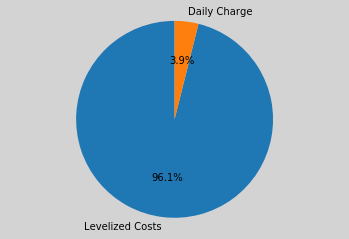

ERROR:ga_logger:panel values: (237.78083171963084, 92.69124835394476, 225.20561117753385, 24.809034318074932, 43.74063381284635, 37.18276036251468, 0.3146883533677074, 0.6326591925894556, 0.7902029960646684)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 24.8
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.706772804260254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 43.7
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.188744306564331 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 37.2
                                           and a gcr of 0.790


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1922543048858643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [87.49597063179952, 0.0, 253.43518098639763]


ERROR:ga_logger:Cost: 3519.2528541582037


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (175.83377504798577, 257.63334263213846, 254.33142529582295, 36.17443704581352, 14.96457002222058, 31.165830853304364, 0.616592591553389, 0.3417759137706416, 0.7218882474014778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 36.2
                                           and a gcr of 0.617


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2300944328308105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 15.0
                                           and a gcr of 0.342


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8918964862823486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 31.2
                                           and a gcr of 0.722


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1636576652526855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [302.45826906150324, 0.0, 0.0]


ERROR:ga_logger:Cost: 3137.1324709165056


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2872655391693115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3375186920166016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.264211893081665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.16115923082754]


ERROR:ga_logger:Cost: 3084.5205097866624


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


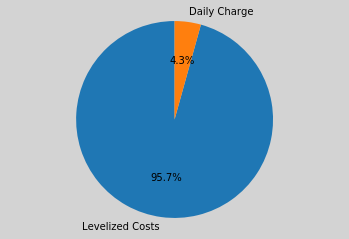

ERROR:ga_logger:panel values: (263.96187766100286, 264.72566660585505, 91.65436866919792, 55.56994668533176, 1.2641458544717197, 1.1949681003343313, 0.20111194776672814, 0.8948806585700466, 0.8997937781787364)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 55.6
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.266655921936035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.3
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2527689933776855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 1.2
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0181448459625244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.89064098907164]


ERROR:ga_logger:Cost: 3469.1894396411217


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (263.4565517427234, 264.5162937345378, 260.0214457560886, 55.8593908934475, 55.992003706305134, 1.4066479139202606, 0.8969497061981826, 0.8917665126495511, 0.20210780650531213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 55.9
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.231968879699707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.22717022895813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 1.4
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0618972778320312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [516.8102135583217, 0.0, 4.5626425068739]


ERROR:ga_logger:Cost: 5311.435918031031


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (264.9325304375193, 96.52544193081557, 90.66354442275544, 55.63899307896099, 1.3272362960332291, 55.40490235801666, 0.8925934501762565, 0.20751011566287297, 0.8213219262504377)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 55.6
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3768413066864014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 1.3
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3065507411956787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.4
                                           and a gcr of 0.821


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418865919113159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [524.0161322711175, 2.4258409414340596, 0.0]


ERROR:ga_logger:Cost: 5361.783403680073


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


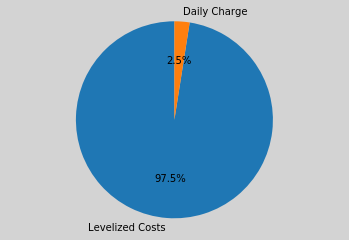

ERROR:ga_logger:panel values: (205.99242339040532, 206.0933444247226, 148.8238986891356, 19.425949011847763, 37.42652829168783, 19.50181316913525, 0.6633959074530597, 0.4354474471767248, 0.652872626117311)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 19.4
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4622278213500977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 37.4
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2847847938537598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 19.5
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.229299306869507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [131.12105540881254, 174.66249684695484, 0.0]


ERROR:ga_logger:Cost: 3170.1598393099575


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (204.77757618245636, 205.78118835467862, 149.5180642594641, 37.28183544525686, 37.24054640852875, 37.54477284812022, 0.44291097250675404, 0.4428268884216121, 0.43707109226157975)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 37.3
                                           and a gcr of 0.443


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2711169719696045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 37.2
                                           and a gcr of 0.443


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3109958171844482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 37.5
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3200719356536865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [265.1981185111646, 0.0, 0.0]


ERROR:ga_logger:Cost: 3722.590927260981


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


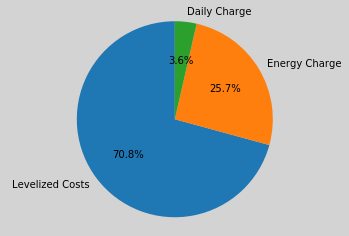

ERROR:ga_logger:panel values: (90.00000000001674, 264.9999999999072, 222.44699885048956, 1.0000000000129374, 55.99999999990562, 1.000000000020648, 0.20000000000015505, 0.6709373918187498, 0.8999999999999022)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.571986436843872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.671


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3011770248413086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5048608779907227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.2795913291628]


ERROR:ga_logger:Cost: 3453.188172657193


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


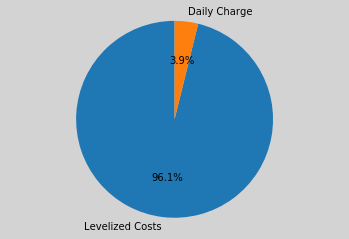

ERROR:ga_logger:panel values: (90.00989740016239, 262.49562882677077, 97.11565708530362, 11.720988777534934, 1.2424969634239322, 1.3127333452459573, 0.5351433304976136, 0.8803929514398563, 0.8867465467600792)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 11.7
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2393622398376465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 1.2
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7794008255004883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 1.3
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.129676580429077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.4815769363456]


ERROR:ga_logger:Cost: 3465.1265337842333


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


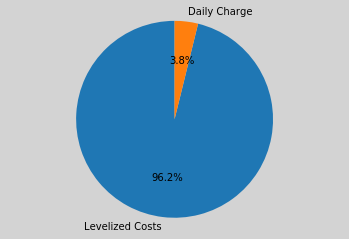

ERROR:ga_logger:panel values: (90.0650238625571, 103.16648687357332, 264.58324086971675, 1.7500628102548579, 42.520760667561746, 2.3580892715294346, 0.562630226265461, 0.22013686892261985, 0.8862140401497804)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.8
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2276618480682373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 42.5
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3366997241973877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 2.4
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2044801712036133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [335.56848670717267, 0.0, 0.0]


ERROR:ga_logger:Cost: 3465.989738917268


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


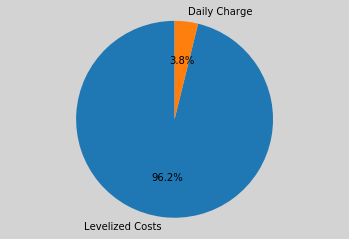

ERROR:ga_logger:panel values: (92.0254056622762, 226.88513664490696, 188.07130005521617, 54.428858625237815, 28.81362752065536, 1.2170817714946054, 0.2980594709887968, 0.5172122522054056, 0.8997234991143563)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 54.4
                                           and a gcr of 0.298


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.220099925994873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 28.8
                                           and a gcr of 0.517


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.207016706466675 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 1.2
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.915071487426758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 297.7120780162825, 20.83092306574573]


ERROR:ga_logger:Cost: 3296.889245970843


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


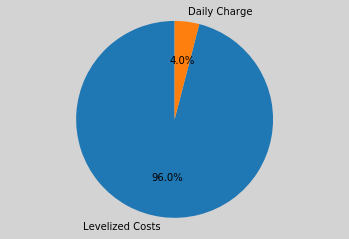

ERROR:ga_logger:panel values: (148.74758136256293, 205.9709815313575, 202.43249793513814, 19.457248284681903, 23.2147862452923, 21.888345679033016, 0.6525296073197513, 0.6192343823503665, 0.6629178110952942)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 19.5
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.296090841293335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 23.2
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2442660331726074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 21.9
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2307536602020264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 306.8404798389062, 0.0]


ERROR:ga_logger:Cost: 3180.657451558325


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (148.76890060030098, 148.70473823283663, 150.45522669334636, 20.705025601191117, 37.45797882751974, 20.792728492303095, 0.4610566524516634, 0.659992370721044, 0.661676953061956)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 20.7
                                           and a gcr of 0.461


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2053778171539307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 37.5
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.212507486343384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 20.8
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2195465564727783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [208.25964899419722, 0.0, 97.3068097856624]


ERROR:ga_logger:Cost: 3168.0036165529627


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (90.00000000006223, 90.00000000021822, 264.9999999993578, 41.35043728561216, 55.999999999355325, 55.99999999965713, 0.8999999999997692, 0.20000000002003776, 0.20000000000105975)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 41.4
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3540432453155518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.204935073852539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2172112464904785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [450.7219261225187, 19.591908210832962, 0.0]


ERROR:ga_logger:Cost: 4804.307485656879


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (90.5997586855119, 263.9814652167828, 91.75416748738276, 1.3315983483018725, 17.67538471812941, 55.5635623588581, 0.2137691278426015, 0.2173459919318597, 0.8999796653914065)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.3
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.111104965209961 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 17.7
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.235413074493408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 55.6
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.196930408477783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.2752004211162948, 0.0, 537.7147287249381]


ERROR:ga_logger:Cost: 5476.480015777004


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (195.2799250066156, 147.50165998879658, 262.4226452118164, 36.54362589582519, 7.363069078982653, 1.282426119087783, 0.20407918578030507, 0.8719943619538577, 0.8880218880222914)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.5
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.247591257095337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 7.4
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1936843395233154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 1.3
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.070777654647827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [62.29460709649278, 255.94294257960973, 0.0]


ERROR:ga_logger:Cost: 3293.8554181523323


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


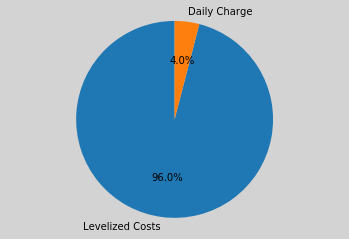

ERROR:ga_logger:panel values: (177.92525783237804, 154.01505152556763, 255.11665317513192, 34.13354755016027, 38.39970880621699, 1.0048131044991817, 0.4402625263037222, 0.40327503562149325, 0.8913730178957491)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 34.1
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3190836906433105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 38.4
                                           and a gcr of 0.403


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3108270168304443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.359760046005249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [224.3102900285472, 0.0, 79.57247381140552]


ERROR:ga_logger:Cost: 3151.2808265573904


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (163.89284643422332, 199.3843624007544, 206.32960507542475, 30.246546380184327, 32.68078103329795, 19.53028507426169, 0.5362448188279638, 0.5406121203402974, 0.6624436628142352)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 30.2
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4551711082458496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 32.7
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3518524169921875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 19.5
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.347679615020752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [299.21812463936743, 0.0, 0.0]


ERROR:ga_logger:Cost: 3104.950701923441


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (179.41444552197314, 169.25092660295786, 159.04776538305276, 31.518558990182978, 29.891763020341557, 19.616140814818014, 0.6637771046842982, 0.6642838313807544, 0.6645100195067268)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 31.5
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.279606342315674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 29.9
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.25180983543396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 19.6
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2849106788635254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [302.608743156232, 0.0, 0.0]


ERROR:ga_logger:Cost: 3138.627006722713


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (182.38041237088336, 256.322623899708, 261.6219848963059, 37.69285406100428, 17.638339023958558, 2.056750744458148, 0.598606183095749, 0.2877086277128391, 0.8999999999998645)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 37.7
                                           and a gcr of 0.599


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3265199661254883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 17.6
                                           and a gcr of 0.288


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.386765241622925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 2.1
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.176175832748413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [300.33455840306954, 0.0, 0.0]


ERROR:ga_logger:Cost: 3116.0393535153553


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


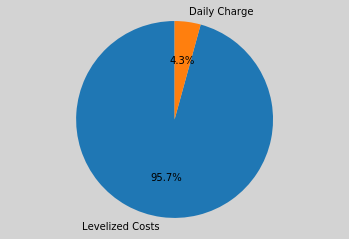

ERROR:ga_logger:panel values: (140.11127912364418, 138.53939062459764, 189.57045641251267, 31.26249909114482, 34.00139218781492, 29.33930260094733, 0.7147308969878268, 0.3833332522155347, 0.5199242326473391)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.3
                                           and a gcr of 0.715


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.340123414993286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 34.0
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.281287908554077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 29.3
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2818362712860107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.5697312538958]


ERROR:ga_logger:Cost: 3078.6463291083355


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


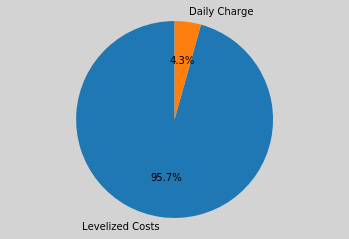

ERROR:ga_logger:panel values: (196.90185451889027, 163.58546917683643, 198.91376702540495, 25.238403975638388, 32.39520724730163, 33.37268400646422, 0.5683432638458872, 0.5830958393255474, 0.5929859325613411)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 25.2
                                           and a gcr of 0.568


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345100164413452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 32.4
                                           and a gcr of 0.583


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.611292839050293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 33.4
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.382706880569458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [300.86266010501566, 0.0, 0.0]


ERROR:ga_logger:Cost: 3121.2845532031324


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (177.4851846468178, 174.41919751523403, 174.20490362581987, 29.238067883049943, 25.48069634447822, 30.314207151372848, 0.5346570985063952, 0.5193612755815591, 0.6078206044723811)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 29.2
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4213294982910156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 25.5
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3042755126953125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 30.3
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.305335283279419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [296.5934733262773, 0.0, 0.0]


ERROR:ga_logger:Cost: 3078.8821403089537


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (180.64858664883604, 173.15917348585685, 179.7087722599388, 28.0008488980022, 27.08016818617978, 26.510595088888756, 0.5431322955764333, 0.5413797841361497, 0.5417765834049832)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 28.0
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5808117389678955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 27.1
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385601758956909 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.5
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4034810066223145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [295.56639924980897, 0.0, 0.0]


ERROR:ga_logger:Cost: 3068.6810347411893


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


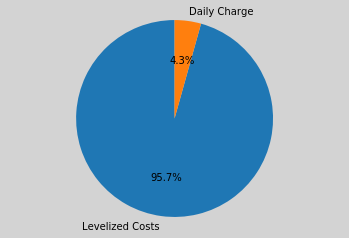

ERROR:ga_logger:panel values: (175.71921337059837, 175.98069144102564, 179.34254964627218, 29.34828233924602, 27.961271770370207, 28.701332643769998, 0.5453608288620106, 0.5595990456894855, 0.5471682930258699)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 29.3
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.388277053833008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.0
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2583537101745605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 28.7
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4735612869262695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.99190711944925]


ERROR:ga_logger:Cost: 3082.8394641371574


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


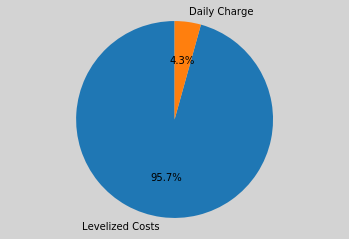

ERROR:ga_logger:panel values: (91.53461954939777, 112.453612315214, 249.55185639573693, 55.66914086312821, 1.2780291822870988, 1.3267016344430984, 0.6735131307902078, 0.6246014588351992, 0.6933824579446715)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 55.7
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.501070976257324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 1.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.141078472137451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 1.3
                                           and a gcr of 0.693


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0046701431274414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 334.35493460794527, 0.0]


ERROR:ga_logger:Cost: 3453.936497102851


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


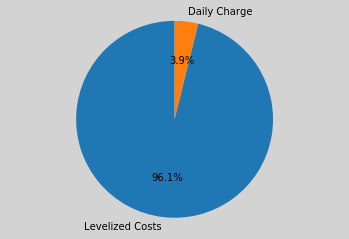

ERROR:ga_logger:panel values: (103.55243929707669, 166.65258011553883, 194.88511453752204, 37.77252891166527, 22.764795761674574, 2.396464682496082, 0.7756521455521692, 0.2130418010917496, 0.879496140630297)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 37.8
                                           and a gcr of 0.776


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4382200241088867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 22.8
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.310148000717163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 2.4
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1748056411743164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 65.36328668496856, 256.7706588432072]


ERROR:ga_logger:Cost: 3332.5551953733625


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (196.96370368735734, 167.6948292726023, 246.94215132929753, 20.890955757713378, 20.48711813292642, 13.733716421943807, 0.6966270256164225, 0.2431834129128916, 0.7527904290775806)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 20.9
                                           and a gcr of 0.697


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4320180416107178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 168
                                           a tilt of 20.5
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2526392936706543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 13.7
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6120431423187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [244.85345252483168, 60.13376095967454, 0.0]


ERROR:ga_logger:Cost: 3162.250438686944


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


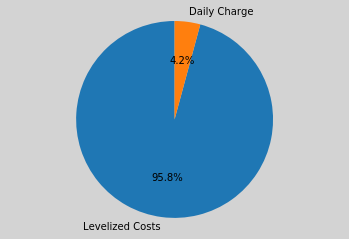

ERROR:ga_logger:panel values: (163.12913233741122, 144.4096809866956, 208.21150157344752, 32.79468596236244, 26.08023906856487, 18.01646713173926, 0.6060367531043166, 0.42854342425508707, 0.6471745454237858)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 32.8
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.498044729232788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 26.1
                                           and a gcr of 0.429


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4450414180755615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 18.0
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9057042598724365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [160.16646918573366, 143.3377498353506, 0.0]


ERROR:ga_logger:Cost: 3147.5210466163603


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


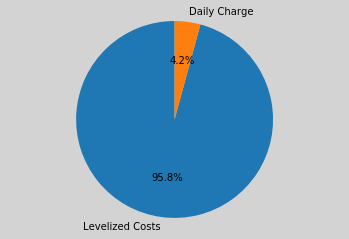

ERROR:ga_logger:panel values: (152.45370940241253, 146.2071808806646, 151.8544541793731, 35.81298992347321, 18.055368866966194, 26.330511525754122, 0.6559493560867999, 0.6437288286866628, 0.4473836218046955)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 35.8
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4708547592163086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 18.1
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6322379112243652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 152
                                           a tilt of 26.3
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3524582386016846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 120.03036654713375, 184.45654045090095]


ERROR:ga_logger:Cost: 3157.281294151139


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


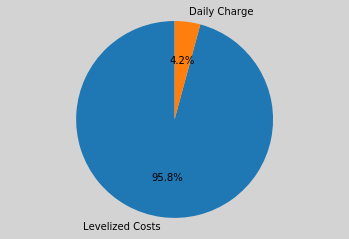

ERROR:ga_logger:panel values: (264.99999999993395, 264.9999999974215, 264.9999999998824, 55.999999999972104, 1.0000000000056077, 38.670716333859346, 0.20000000000010396, 0.89999999999968, 0.6899191039915922)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5163068771362305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.357736825942993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 38.7
                                           and a gcr of 0.690


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6429555416107178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 336.2732025819976, 0.0]


ERROR:ga_logger:Cost: 3472.9891177509203


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


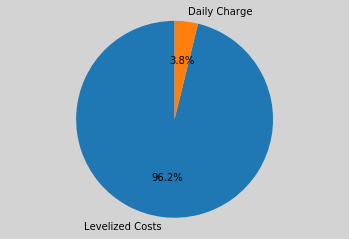

ERROR:ga_logger:panel values: (91.8528744179322, 114.68733037235454, 235.1633077916591, 9.676656824946056, 55.18371687182742, 2.780447622236028, 0.8926815584352994, 0.8921766844039729, 0.898465343423704)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 9.7
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4669253826141357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 55.2
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3374884128570557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 2.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2268869876861572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 333.05578781846987]


ERROR:ga_logger:Cost: 3441.0331122501707


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


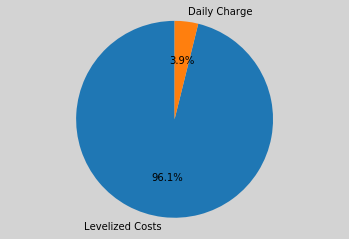

ERROR:ga_logger:panel values: (92.38352672208522, 222.28726860420784, 259.01270508317475, 52.47725672583212, 1.224411371561557, 38.273707305321174, 0.419190229180349, 0.8976994613084286, 0.8984037762526615)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 52.5
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9008102416992188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 1.2
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8857290744781494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 38.3
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4317119121551514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 333.8557830010584, 0.0]


ERROR:ga_logger:Cost: 3448.978823739061


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


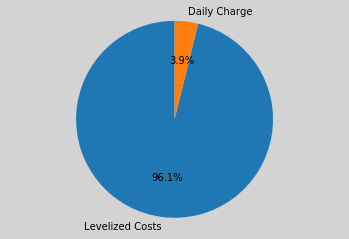

ERROR:ga_logger:panel values: (264.46300080296567, 248.32683915682892, 254.82017746552904, 1.8208376289742159, 5.346614683705713, 1.3308534189442587, 0.51931110072298, 0.8244721975716938, 0.8933724926737094)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.8
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.39396333694458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 5.3
                                           and a gcr of 0.824


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.370864152908325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9624600410461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 333.8110772973124, 0.0]


ERROR:ga_logger:Cost: 3448.5347987844107


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


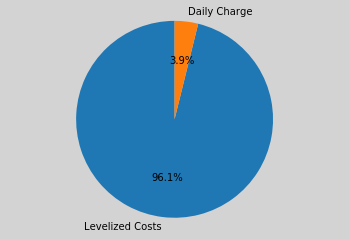

ERROR:ga_logger:panel values: (154.88263532106828, 164.73868040247464, 178.44301257827826, 23.36505256573293, 36.12534084851291, 21.071024808145772, 0.6581890332689871, 0.46366147471901753, 0.6252190447125989)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 23.4
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6150310039520264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 36.1
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.394620656967163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 21.1
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360149383544922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 216.8585490091825, 81.93676113941828]


ERROR:ga_logger:Cost: 3100.751224806354


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


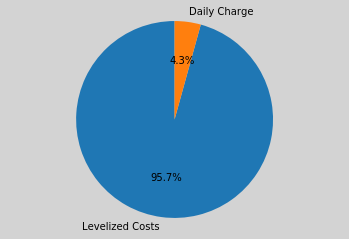

ERROR:ga_logger:panel values: (154.78308475713538, 156.33345978942117, 183.05550203009835, 28.828600849992945, 28.78032272369437, 27.443216893334355, 0.6578700052182558, 0.5156952747589831, 0.557309588752432)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 28.8
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9056451320648193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 28.8
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2871196269989014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 27.4
                                           and a gcr of 0.557


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.329697370529175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.4572427776222]


ERROR:ga_logger:Cost: 3077.5290703659766


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


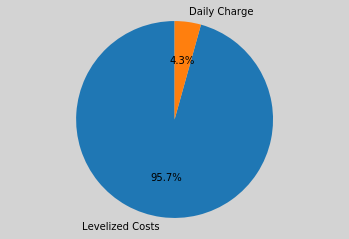

ERROR:ga_logger:panel values: (181.90728128593273, 224.85034439828576, 248.00685586123413, 32.88646485607099, 20.73602724271815, 18.477818084978292, 0.591569865509719, 0.4056820291522896, 0.7919216092207959)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 32.9
                                           and a gcr of 0.592


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.801147222518921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 20.7
                                           and a gcr of 0.406


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3471415042877197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 18.5
                                           and a gcr of 0.792


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3153324127197266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [297.8898435218057, 0.0, 0.0]


ERROR:ga_logger:Cost: 3091.7579525156557


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


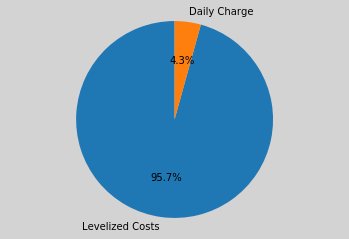

ERROR:ga_logger:panel values: (92.47145888236945, 245.89505506858333, 90.44433898125513, 2.614841578709711, 55.76771308290287, 1.2628741345827352, 0.8955240751460791, 0.8574899825020093, 0.7016164038088617)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 2.6
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4728894233703613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 55.8
                                           and a gcr of 0.857


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.516148805618286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.3
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3397529125213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.73814209120445]


ERROR:ga_logger:Cost: 3467.674790065384


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


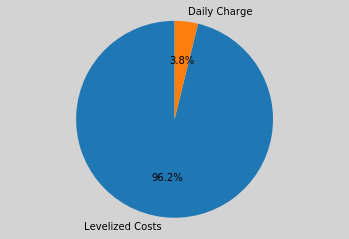

ERROR:ga_logger:panel values: (91.05695648466845, 92.5562630817538, 90.3400282769701, 23.438599878771296, 46.08240766623149, 1.8264577155226855, 0.8711050563850782, 0.8630797403769332, 0.3947763113421904)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 23.4
                                           and a gcr of 0.871


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4736123085021973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 46.1
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.199782609939575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.8
                                           and a gcr of 0.395


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1956396102905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [244.39140590792226, 0.0, 125.62112747404913]


ERROR:ga_logger:Cost: 3808.094899979872


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


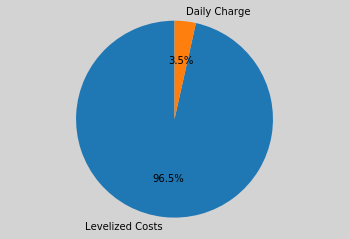

ERROR:ga_logger:panel values: (184.98938574035603, 263.0947687438011, 205.5137911719225, 53.68329403543127, 2.107065429788837, 7.921608738812947, 0.41926696557958176, 0.7801130112245374, 0.8668103273365615)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 53.7
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.539201259613037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 2.1
                                           and a gcr of 0.780


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.053781270980835 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 7.9
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5635225772857666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [190.93946584887772, 0.0, 124.25644959081704]


ERROR:ga_logger:Cost: 3263.6453166890888


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


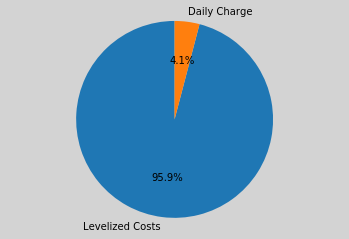

ERROR:ga_logger:panel values: (199.76471744530198, 195.89660252285495, 204.63181092007673, 26.581093879005085, 21.615495723586882, 21.823240860093506, 0.6361109801509249, 0.4279514224130141, 0.6513561625036697)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 26.6
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.663908004760742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 21.6
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2805068492889404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 21.8
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.259705066680908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [139.06839620211827, 162.68095297613917, 0.0]


ERROR:ga_logger:Cost: 3130.0913247736917


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


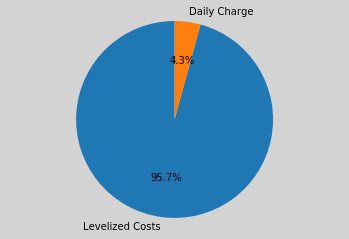

ERROR:ga_logger:panel values: (175.92697084893368, 167.3051375389187, 182.51407453742686, 27.80839421749543, 25.57320833839919, 26.384239901664838, 0.5595448471803942, 0.5430793811986354, 0.6040543590794589)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 27.8
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.544074296951294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 25.6
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2367196083068848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 26.4
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1803267002105713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [297.65171654799013, 0.0, 0.0]


ERROR:ga_logger:Cost: 3089.3928226334524


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (139.91486153726422, 151.8524041013997, 189.94661129284555, 31.14049410704435, 33.56100084174942, 26.746514831769378, 0.7036756562218984, 0.42685053575993426, 0.5494401444009887)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.1
                                           and a gcr of 0.704


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5421719551086426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 33.6
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.263843536376953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 26.7
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2313342094421387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.84902190273874]


ERROR:ga_logger:Cost: 3091.3524977697252


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


ERROR:ga_logger:panel values: (191.64487537433928, 162.89895172072994, 180.212658248636, 36.579045963676975, 27.163507624448396, 23.689313554885448, 0.5223037780511435, 0.44093863299728864, 0.49003797301682944)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 36.6
                                           and a gcr of 0.522


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4672322273254395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 27.2
                                           and a gcr of 0.441


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.225602626800537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 23.7
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.36277174949646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [47.11806767029094, 0.0, 249.20865565248613]


ERROR:ga_logger:Cost: 3076.2327227731644


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


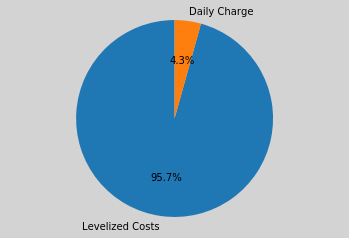

ERROR:ga_logger:panel values: (172.41407940217596, 173.86723169731536, 186.78741938936142, 24.93628131456413, 25.290346932525445, 27.683186318474757, 0.509937751729217, 0.5050673335238514, 0.5112798730348329)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 24.9
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4337010383605957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 25.3
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.145691156387329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 27.7
                                           and a gcr of 0.511


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0387139320373535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.8838796447412]


ERROR:ga_logger:Cost: 3071.834312512728


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


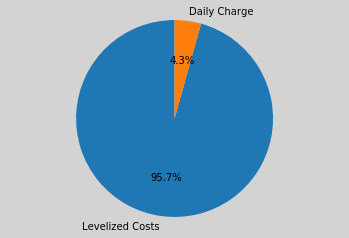

ERROR:ga_logger:panel values: (183.29461371187824, 178.21311609421358, 182.86186745507638, 28.35549405636895, 25.220919496929017, 26.927750546336135, 0.5665713478339686, 0.5392490145471778, 0.53587644540274)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 28.4
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5283679962158203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 25.2
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2381222248077393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 26.9
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2738661766052246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.93723193778226]


ERROR:ga_logger:Cost: 3072.3642180316724


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


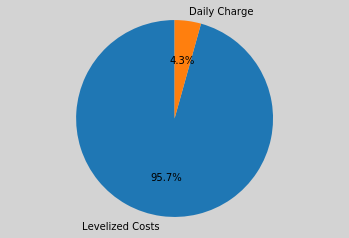

ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


In [28]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10 )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10)
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i)+10)
    pvoptimizer.processGA(ga_fina)

